In [ ]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
data = pd.read_csv('/content/Gurami-Eceran.csv', sep =',')

In [ ]:
new_data = np.array_split(data, 6)


In [ ]:
def remove_outlier(df1):
  Q1 = df1['Harga'].quantile(0.25)
  Q3 = df1['Harga'].quantile(0.75)
  IQR = Q3 - Q1
  # df = df1[(df1['Harga'] >= Q1 - 1.5 * IQR) & (df1['Harga'] <= Q3 + 1.5 * IQR)]
  threshold = 1.5*IQR
  median = np.median(df1['Harga'])
  outliers = (df1['Harga'] < Q1 - threshold) | (df1['Harga'] > Q3 + threshold)
  df1[outliers] = median
  return df1


In [ ]:
df=pd.DataFrame()
for i in range(len(new_data)):
  new_data[i] = remove_outlier(new_data[i])


In [ ]:
df = pd.concat(new_data)

In [ ]:
def get_data(data):
    
    times = []
    value = []

    i = 0
    for row in data:
      times.append(i)
      value.append(float(row)/1000)
      i+=1

    
    return times, value


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    times, price = get_data(df['Harga'])
    TIME = np.array(times)
    SERIES = np.array(price)
    SPLIT_TIME = 62
    WINDOW_SIZE = 12
    BATCH_SIZE = 12
    SHUFFLE_BUFFER_SIZE = 150


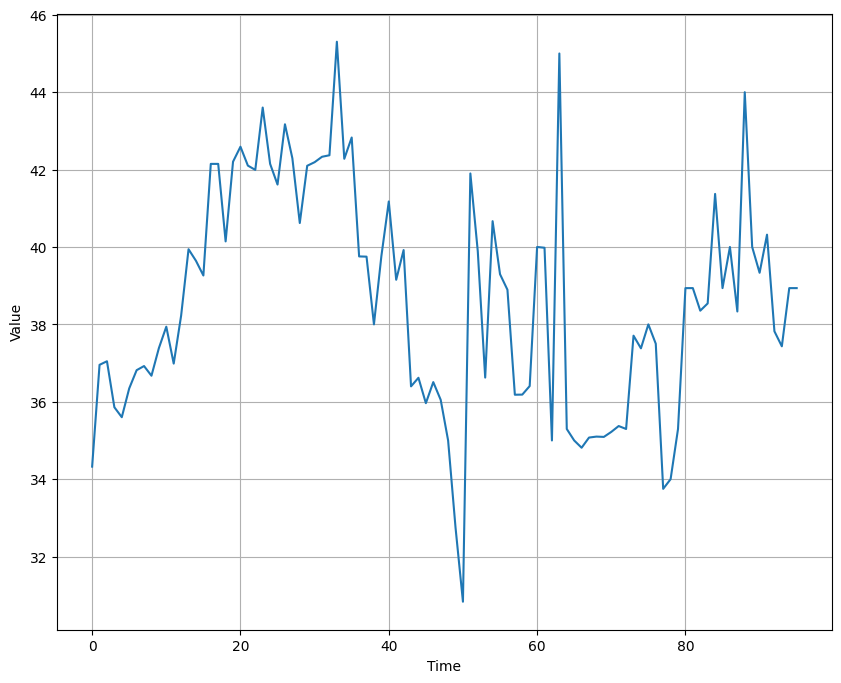

In [ ]:
plt.figure(figsize=(10, 8))
plot_series(G.TIME, G.SERIES)
plt.show()

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

In [ ]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [ ]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Build the Model

In [ ]:
def create_model():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100)
    ]) 

    return model
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 12, 32)            128       
                                                                 
 bidirectional_8 (Bidirectio  (None, 12, 256)          164864    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
 lambda_2 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 329,473
Trainable params: 329,473
Non-tr

In [ ]:
# Test your uncompiled model
uncompiled_model = create_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

5/5 [==============================] - 2s 16ms/step
Your current architecture is compatible with the windowed dataset! :)


In [ ]:
# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.95)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
# model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = 1e-06

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.95)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
Epochs = 80
history = model.fit(train_set,epochs=Epochs)

Epoch 1/80
5/5 [==============================] - 9s 53ms/step - loss: 8.8733 - mae: 9.3668
Epoch 2/80
5/5 [==============================] - 0s 46ms/step - loss: 12.4631 - mae: 12.9631
Epoch 3/80
5/5 [==============================] - 0s 43ms/step - loss: 6.7498 - mae: 7.2467
Epoch 4/80
5/5 [==============================] - 0s 87ms/step - loss: 10.5243 - mae: 11.0243
Epoch 5/80
5/5 [==============================] - 0s 84ms/step - loss: 5.3804 - mae: 5.8706
Epoch 6/80
5/5 [==============================] - 0s 79ms/step - loss: 4.4063 - mae: 4.8902
Epoch 7/80
5/5 [==============================] - 0s 79ms/step - loss: 7.3958 - mae: 7.8868
Epoch 8/80
5/5 [==============================] - 0s 58ms/step - loss: 4.2790 - mae: 4.7650
Epoch 9/80
5/5 [==============================] - 0s 43ms/step - loss: 4.2726 - mae: 4.7631
Epoch 10/80
5/5 [==============================] - 0s 44ms/step - loss: 4.5900 - mae: 5.0818
Epoch 11/80
5/5 [==============================] - 0s 42ms/step - loss: 2.9

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [ ]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [ ]:
cnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
cnn_forecast = cnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
mse, mae = compute_metrics(series_valid, cnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

8/8 [==============================] - 2s 27ms/step
mse: 5.96, mae: 1.76 for forecast


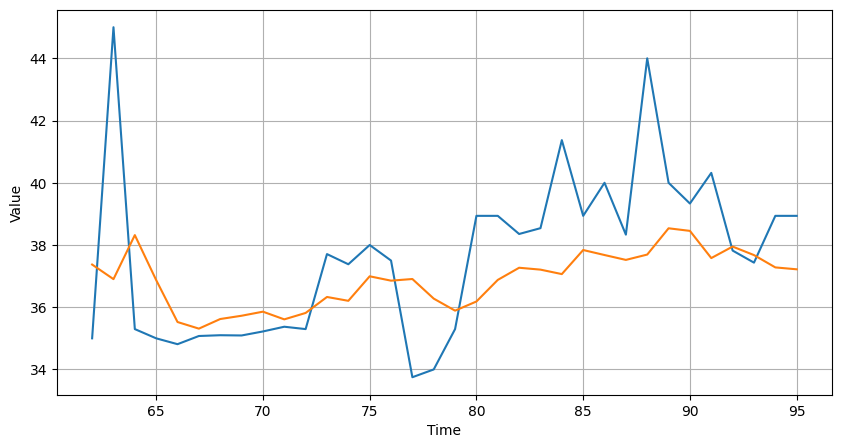

In [ ]:
# Plot the forecast
plt.figure(figsize=(10, 5))
plot_series(time_valid, series_valid)
plot_series(time_valid, cnn_forecast)

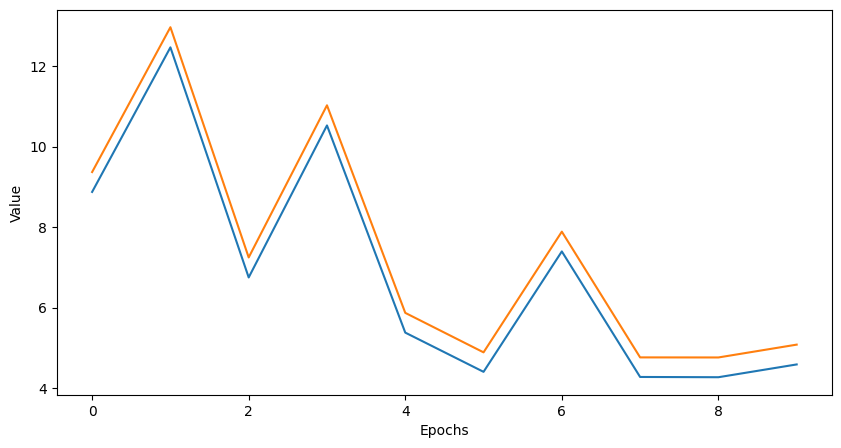

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(10), history.history["loss"][:10])
plt.plot(range(10), history.history["mae"][:10])
plt.xlabel("Epochs")
plt.ylabel("Value")

plt.show()

In [ ]:
# prepare data for forecasting
last_window = G.SERIES[-G.WINDOW_SIZE:]
last_window = np.reshape(last_window, (1, G.WINDOW_SIZE, 1))

# make a forecast for 5 steps ahead
forecast_norm = []
for _ in range(24):
    pred = model.predict(last_window)[0, 0]
    forecast_norm.append(pred)
    last_window = np.roll(last_window, -1, axis=1)
    last_window[0, -1, 0] = pred

# invert the normalization
forecast = forecast_norm
print("Forecast:", forecast)

1/1 [==============================] - 0s 32ms/step
Forecast: [37.787785, 37.41101, 37.46074, 36.90285, 37.242447, 37.175636, 37.011574, 37.20966, 37.221176, 37.084084, 37.045128, 37.085773, 37.078815, 37.05373, 37.09581, 37.05655, 37.064476, 37.07535, 37.05655, 37.05226, 37.057793, 37.05825, 37.054295, 37.054474]


In [ ]:
model.save('Gurame(Eceran).h5')